In [1]:
import os
import glob2 as glob
import numpy as np
import SimpleITK as sitk

import pickle, warnings
import seaborn as sns

In [2]:
def read_nii_from_file(filename, is_label=False):
    sitk_niim = sitk.ReadImage(filename)
    niim = sitk.GetArrayFromImage(sitk_niim)
    return niim

In [3]:
def im_normalize(im):    
    im_mean = np.mean(im)
    im_std = np.std(im)
    
    im_uplimit = im_mean + .5*im_std
    im_lowlimit = 0
    
    im[im > im_uplimit] = im_uplimit
    im[im < im_lowlimit] = im_lowlimit
    
    im = (im - np.min(im)) / (np.max(im) - np.min(im)) * 255
    
    return im

In [4]:
def fill_im_with_data(im_in, CH_DIM=64, Z_DIM=24, XY_DIMS = [256, 256]):
    if len(im_in.shape) == 4:
        im = np.zeros((CH_DIM, Z_DIM, XY_DIMS[0], XY_DIMS[1]))
        z_idx = 1
    else:
        im = np.zeros((Z_DIM, XY_DIMS[0], XY_DIMS[1]))
        z_idx = 0
    
    z_start = int(Z_DIM/2 - np.ceil(im_in.shape[z_idx]/2))
    
    if len(im_in.shape) == 4:
        im[:im_in.shape[0], z_start:z_start + im_in.shape[1], :, :] = im_in
    else:
        im[z_start:z_start + im_in.shape[0], :, :] = im_in
    
    return im

In [6]:
MIN_DWI_ZDIM = 28
with open('isles_4ddwi_svd.pkl', 'rb') as f:
    u, s = pickle.load(f)

In [21]:
CH_DIM = 64
Z_DIM = 24
def write_3d_im(subjects, save_dir):
    for casei, case in enumerate(subjects):
        imct = None
        im4dwi = None
        imlb = None
        for subdir, dirs, files in os.walk(case):
            for file in files:
                if file.endswith('.nii'):
                    if 'O.OT.' in file:
                        is_label = True
                    else:
                        is_label = False

                    im = read_nii_from_file(os.path.join(subdir, file), is_label=is_label)
                    im = fill_im_with_data(im, CH_DIM, Z_DIM)

                    if '_4DPWI.' in file:
                        _im4dwi = im
                        im4dwi = np.tensordot(np.transpose(u[:,:2]), im[:MIN_DWI_ZDIM,:], axes=(1, 0))
                        #im4dwi = np.swapaxes(im4dwi, 0, 1)
                        #im4dwi = np.swapaxes(im4dwi, 1, 2)
                        #im4dwi = np.swapaxes(im4dwi, 2, 3)
                    elif 'O.CT.' in file:
                        imct = im
                    elif '_CBF.' in file:
                        imcbf = im
                    elif '_CBV.' in file:
                        imcbv = im
                    elif '_MTT.' in file:
                        immtt = im
                    elif '_Tmax.' in file:
                        imtmax = im
                    elif 'O.OT.' in file:
                        imlb = im
                    else:
                        continue

        im4dwi0 = -1*im4dwi[0,:]
                        
        im4dwi_nm = im_normalize(im4dwi0)
        imct_nm = im_normalize(imct)
        imcbf_nm = im_normalize(imcbf)
        imcbv_nm = im_normalize(imcbv)
        immtt_nm = im_normalize(immtt)
        imtmax_nm = imtmax * 10
        
        _im4dwi_nm = im_normalize(_im4dwi)
        
        if imlb is None:
            imlb = np.zeros_like(imct)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
#             im4d = np.stack([imct_nm, imcbf_nm, imcbv_nm, 
#                              immtt_nm, imtmax_nm], axis=3)
#             im4d = np.concatenate((im4d, im4dwi_nm), axis=3)
            im4d = np.stack([imct_nm, im4dwi_nm, imtmax_nm], axis=3)

            imfname = os.path.join(save_dir,
                                   os.path.basename(os.path.normpath(case)) +
                                   '_4d' + '.pkl')
            with open(imfname, 'wb') as f:
                pickle.dump(im4d, f)

            im4d2 = np.stack([imcbf_nm, imcbv_nm, immtt_nm], axis=3)
            im2fname = os.path.join(save_dir,
                                   os.path.basename(os.path.normpath(case)) +
                                   '_4d2' + '.pkl')
            with open(im2fname, 'wb') as f:
                pickle.dump(im4d2, f)
                
            lb3d = imlb * 255
            lbfname = os.path.join(save_dir,
                                   os.path.basename(os.path.normpath(case)) +
                                   '_lb_3d' + '.pkl')
            with open(lbfname, 'wb') as f:
                pickle.dump(lb3d, f)
                
            lb3d = imlb * 255
            lbfname = os.path.join(save_dir,
                                   os.path.basename(os.path.normpath(case)) +
                                   '_lb_3d' + '.pkl')
            with open(lbfname, 'wb') as f:
                pickle.dump(lb3d, f)
                
            lb3d2 = np.stack([_im4dwi_nm[0,:], lb3d, _im4dwi_nm[-1,:]], axis=3)
            lb2fname = os.path.join(save_dir,
                                   os.path.basename(os.path.normpath(case)) +
                                   '_lb_3d2' + '.pkl')
            with open(lb2fname, 'wb') as f:
                pickle.dump(lb3d2, f)

In [22]:
subjects = glob.glob('/datasets/isles18/TRAINING/case_*/')
write_3d_im(subjects, '/datasets/isles18/training_4d')

In [23]:
subjects = glob.glob('/datasets/isles18/TESTING/case_*/')
write_3d_im(subjects, '/datasets/isles18/testing_4d')

In [9]:
lb3d.shape

(24, 256, 256)

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

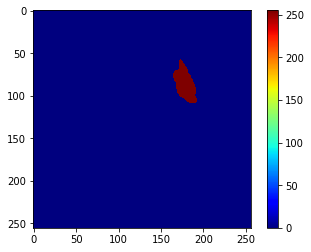

In [11]:
plt.figure()
plt.imshow(lb3d[12,:,:], cmap=plt.cm.jet)
plt.colorbar()
plt.show()

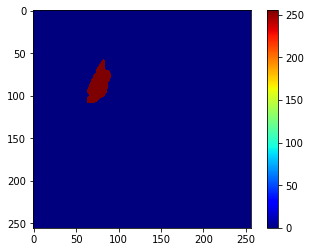

In [12]:
lb3dfp = np.flip(lb3d, 2)
plt.figure()
plt.imshow(lb3dfp[12,:,:], cmap=plt.cm.jet)
plt.colorbar()
plt.show()